# Modeling , Param Tuning, Evulating, Explaining & Prediction

In [195]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle 
import warnings
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss,roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import category_encoders as ce
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import FunctionTransformer
import shap
import json
import imblearn

import DATA_PROCESSING as process
%pylab inline
pd.set_option('display.max_rows', 500)

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy


# Running parameters

In [196]:
SAMPLE = 2000
USE_SMOTE = False
CALC_PARAMS = False
dev_mode = True
config_file = "configuration_01_15_2022__08_18_sample_1000000.csv"


In [197]:
columns_cum =['app_cat','manufacturer','device_model','device_version','user_isp']
columns_dummies=['banner_pos', 'Day_of_Week','state','manufacturer','Month','hour','user_isp','app_cat','device_model','device_version']
features = ['state', 'user_isp', 'app_cat', 'banner_pos', 'manufacturer', 'device_model', 'device_version', 'device_height', 'device_width', 'device_diag', 'Day_of_Week', 'Month', 'hour']
cat_features = ['state', 'user_isp', 'app_cat', 'banner_pos', 'manufacturer', 'device_model', 'device_version', 'Day_of_Week', 'Month', 'hour']

# Read Training Data

In [198]:
df = pd.read_pickle("train_set.pickle").sample(n=SAMPLE)
df.loc[:,"clicked"] = df.loc[:,"clicked"].map({True:1, False:0})

### Imputing, Feature engineering,Cardinality reductions , and dummy coding 

In [199]:
def preprocessing_pipeline(df, one_hot_encoding=True, allowed_levels_dict = None):
    df= df.drop(['op_id', 'resolution','app_id'], axis=1)
    # if  a dict of categorical columns and theyr allowed levels is given - replace levels not in the list as "<col_name>_other"
    if allowed_levels_dict:
        for col_name, categories_list in allowed_levels_dict.items():
            df.loc[:, col_name] = df[col_name].map(lambda x: x if x in categories_list else f"{col_name}_other")
    df=process.Missing_values(df)
    df=process.Feature_engineering(df)
    if not allowed_levels_dict:
        df, cat_dict = process.cumulatively_categorise(df,columns_cum)
    if one_hot_encoding:
        df=process.get_dummies_fun(df,columns_dummies)
    return df,allowed_levels_dict if allowed_levels_dict else cat_dict 

In [200]:
%%time
df, allowed_levels_dict = preprocessing_pipeline(df, one_hot_encoding=USE_SMOTE)
MODEL_COLS = list(df.columns)
df.shape

summary of missing values before imputing missing data: 
manufacturer    596
device_model    596
dtype: int64
summary of missing values after imputing missing data based on device version
manufacturer    39
device_model    39
dtype: int64
summary of missing values after imputing missing data by assigning a separate category
Series([], dtype: int64)
Wall time: 2.19 s


(2000, 14)

# exploring the Target Encoder

for classification tasks Target encoding is a novel and usefull method for converting high-cardinality categorical variable to a continuous value by encoding for each level the propoprion of rows in which Y=1\
i.e. for click prediction it encodes the ctr for each level over the entire dataset



encoder = ce.TargetEncoder(cols=cat_features)
encoded = encoder.fit_transform(df[features], df['clicked'])
encoded.describe()

# look at Class (Im)Balance

In [201]:
df.groupby('clicked').clicked.count()

clicked
0    1861
1     139
Name: clicked, dtype: int64

# splitting the data test to 3 parts:
1. training: 80%
2. validation: 10% - for param tunning 
3. test set: 10% a final test set to evaluate the perfromance of the final model, only after all tunning has completed.

In [202]:
train_df, other = train_test_split(df, test_size=0.2, random_state=42)
dev_val, dev_test = train_test_split(other, test_size=0.5, random_state=42)


In [203]:
train_df.shape, dev_val.shape,  dev_test.shape

((1600, 14), (200, 14), (200, 14))

# SMOTE oversampling - on the training set only

In [204]:
def appply_smote(df):
    cat_features =  [c for c in df.columns if 'device_' not in c and c != 'clicked']
    features =  [c for c in df.columns if c != 'clicked']
    
    kw_args={
                'y':df['clicked'],
                'X_cols' :list(df[features].columns),
                'y_cols' :list(df[['clicked']].columns)
            }
    smote_transformer = FunctionTransformer(process.Smote_alg,kw_args=kw_args,validate=True)

    smote_pipe = Pipeline([('smote', smote_transformer)])
    new_df, new_y = smote_pipe.fit_transform(df[features])

    #print ('Before', df[features].shape, df['clicked'].shape, 'After', new_df.shape, new_y.shape)
    
    new_df.loc[:, 'clicked'] = new_y['clicked']
    df = new_df[MODEL_COLS]
    cat_features = []
    return df, features, cat_features



In [205]:
#TODO add the explanation here
if USE_SMOTE:
    train_df, features, cat_features = appply_smote(train_df)
    

In [206]:
dev_val.head()

,state,user_isp,app_cat,banner_pos,manufacturer,device_model,device_version,device_height,device_width,clicked,device_diag,Day_of_Week,Month,hour
1198,Oregon,user_isp_other,games - simulation,center,LG,SM-J327T1,7.0,720,1280,0,45.0,Thursday,Aug,evening
720,Ohio,AT&T Wireless,games - simulation,bottom-left,ZTE,Z835,7.1.1,480,854,0,26.0,Thursday,Sep,evening
1381,Washington,user_isp_other,app_cat_other,right,Samsung,device_model_other,7.0,720,1280,0,45.0,Sunday,Sep,day
63,Georgia,user_isp_other,games - arcade,top-right,ZTE,3632A,7.1.1,854,480,0,26.0,Friday,Aug,night
630,Illinois,AT&T U-verse,games - word,top-left,manufacturer_other,K88,7.1.1,1280,800,0,40.0,Saturday,Sep,day


In [207]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 968 to 1126
Data columns (total 14 columns):
state             1600 non-null object
user_isp          1600 non-null object
app_cat           1600 non-null object
banner_pos        1600 non-null object
manufacturer      1600 non-null object
device_model      1600 non-null object
device_version    1600 non-null object
device_height     1600 non-null int64
device_width      1600 non-null int64
clicked           1600 non-null int64
device_diag       1600 non-null float64
Day_of_Week       1600 non-null object
Month             1600 non-null object
hour              1600 non-null object
dtypes: float64(1), int64(3), object(10)
memory usage: 187.5+ KB


In [208]:
X_train = train_df[features]
y_train = train_df['clicked']
X_val = dev_val[features]
y_val = dev_val['clicked']


In [209]:
def get_config(model):
    d = configs.loc[model].params
    params = json.loads(d)
    print (params)
    return (params)
configs = pd.read_csv(config_file).set_index('index')
configs

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
index,,,,,,,
RF,0.93263,0.002963,0.714286,0.836871,-2.326877,0.220281,"{""class_weight"": null, ""criterion"": ""gini"", ""m..."
knn,0.93254,0.001778,0.571429,0.839289,-2.329986,0.340000,"{""leaf_size"": 30, ""n_neighbors"": 1000, ""weight..."
catboost,0.93301,0.007409,1.000000,0.868186,-2.313753,0.947592,"{""min_data_in_leaf"": 100, ""depth"": 8, ""l2_leaf..."


# Preparing for pipeline creation

In [210]:
def plot_auc(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.3f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

In [211]:

def plot_calibration(y, y_hat):
    # reliability diagram
    fop, mpv = calibration_curve(y, y_hat, n_bins=10, normalize=True)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.plot(mpv, fop, marker='.')
    plt.xlabel("Mean predicted probabilities")
    plt.ylabel("True Probabilities")
    plt.title("Calibration Curve")
    pyplot.show()

In [212]:
def find_threshold_by_accuracy(y, y_hat, plot=False):
    threshold = []
    accuracy = []
    for p in np.sort(np.unique(y_hat))[-50:]:
        threshold.append(p)
        y_pred = (y_hat >= p).astype(int)
        curr_accuracy = accuracy_score(y,y_pred)
        accuracy.append(curr_accuracy)
    best_threshold = threshold[np.argmax(np.array(accuracy), axis=0)]
    best_accuracy = max(accuracy)
    print ("Best Threshold:" ,best_threshold, ", with accuracy = ", best_accuracy)
    if plot:
        plt.scatter(threshold,accuracy)
        plt.xlabel("Threshold")
        plt.ylabel("Accuracy")
        plt.show()
    return best_accuracy, best_threshold

In [213]:

def find_best_params_random_forest(grid, X_train, y_train, X_val, y_val):
    best_metric = float('-inf')
    worst_metric = float('inf')
    for g in ParameterGrid(grid):
        print(g)
        rf_pipe = make_rf_pipe_line(None, params = g, target_encoding = (USE_SMOTE == False))
        rf_pipe.fit(X_train,y_train)
        y_hat = rf_pipe.predict_proba(X_val)[:,1]
        #curr_metric, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_hat, pos_label=1)
        curr_metric = auc(fpr, tpr)
        # save if best
        if curr_metric > best_metric:
            best_metric = curr_metric
            best_grid = g
            
        if curr_metric < worst_metric:
            worst_metric = curr_metric
            worst_grid = g
    print ("Final Result")
    print ("best metric", best_metric, ", Grid:", best_grid)
    print ("worst metric", worst_metric, ", Grid:", best_grid)
    return best_grid

In [214]:
def evaulate_pipeline(pipe, X, y, params):
    y_hat = pipe.predict_proba(X)[:,1]
    assert y.shape ==  y_hat.shape
    best_accuracy, best_threshold = find_threshold_by_accuracy(y_val, y_hat, plot=False)
    
    y_pred = (y_hat >= best_threshold).astype(int)

 
    fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=1)
    auc = plot_auc(fpr, tpr)
    plot_calibration(y, y_hat)
    #plt.hist(y_hat[y_hat >= 0], bins=10, density=False)
    plt.hist(y_hat, bins=100, density=True)
    plt.title("Histogram of predicted probabilities for click")
    plt.show()
   
    result = {
        "Accuracy": accuracy_score(y, y_pred, normalize=True),
        "Recall": recall_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "AUC": auc,
        "-LogLoss(higer is better)": -log_loss(y, y_pred),
        "threshold":   best_threshold,
        "params": json.dumps(params)
    }
    return result
    

In [215]:
identity  = FunctionTransformer(lambda x:x, validate=True)

# Model 1: Random Forest PipeLine

In [216]:
def make_rf_pipe_line(calibration = None, params = None , target_encoding = True):
    assert calibration is None or calibration in ['isotonic', 'sigmoid']
    encoder = ce.TargetEncoder(cols=cat_features) if target_encoding else identity
    rf = RandomForestClassifier(n_estimators = 200, max_depth=5, criterion = "gini", n_jobs = 4,
                                min_samples_split=100,random_state=13)
    if params:
        rf.set_params(**params)
    if calibration is None:
        rf_pipe = Pipeline([('target_enc',encoder),  ('classifier', rf)])
    else:
        calibrated_RF_classifier =  CalibratedClassifierCV(base_estimator=rf, cv=5, method=calibration)
        rf_pipe = Pipeline([('target_enc',encoder),  ('calibrated_classifier', calibrated_RF_classifier)])
    rf_pipe.fit(X_train, y_train)
    return rf_pipe


### Parameters being tuned:
1. min_samples_leaf = the minimal number of observations in a new leaf that are required in order for creating it
2. max_depth        = the maximal depth that is allowed in each tree (# splits a in any directed path)
3. class_weight     = the strategy for creating class weights to handle imbalanced data
4. n_estimators     = the totl number of trees in the forest
5. criterion        = the metric for calculating improvement in information by the node splitting: Gini inequality or entropy

In [217]:
# this is a long step, was executed and saved previously

if CALC_PARAMS:

    if dev_mode:
        rf_params_grid ={'min_samples_leaf': [50, 100], 
                     'max_depth': [3,5] ,
                     'class_weight' : ['balanced'],
                     'n_estimators': [100],
                     'criterion': ["gini"]

                    }     
    else:    
        rf_params_grid ={'min_samples_leaf': [50, 100, 500], 
                         'max_depth': [3,5] ,
                         'class_weight' : ['balanced', None],
                         'n_estimators': [100, 200],
                         'criterion': ["gini"]

                        }
    best_rf_params = find_best_params_random_forest(rf_params_grid, X_train, y_train, X_val, y_val)
else:
    get_config
    best_rf_params = get_config('RF')


{'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 100, 'n_estimators': 200}


In [218]:

rf_pipe = make_rf_pipe_line(calibration = 'sigmoid' if USE_SMOTE else None,
                            params = best_rf_params,
                            target_encoding = (USE_SMOTE==False))


Best Threshold: 0.18743047840709917 , with accuracy =  0.96


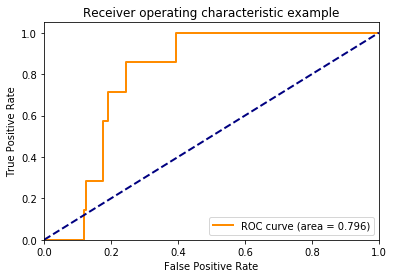

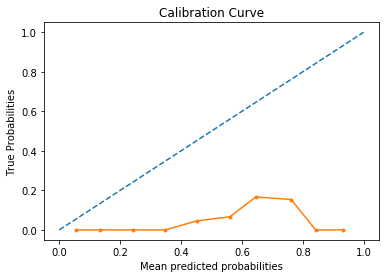

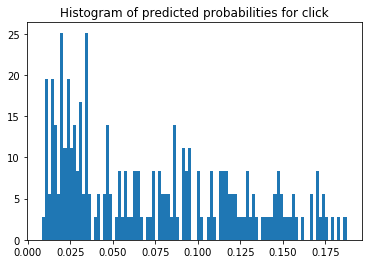

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
RF,0.96,0.0,0.0,0.796447,-1.381555,0.18743,"{""class_weight"": null, ""criterion"": ""gini"", ""m..."


In [219]:
rf_results = evaulate_pipeline(rf_pipe, X_val, y_val,best_rf_params)
rf_df = pd.DataFrame(rf_results, index= ['RF'])
rf_df

# Model 2: CatBoost 

In [220]:
X_val = dev_val[features]
y_val = dev_val['clicked']

In [221]:
validation_pool = Pool(data = X_val, label = y_val, cat_features=cat_features)
train_pool = Pool(data = X_train, label = y_train, cat_features=cat_features)


In [222]:
def make_catboost_pipe_line(train_pool, validation_pool , class_weight = None, target_encoder = False, params = None):
    model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features= cat_features ,
                               depth=5,
                               custom_loss = ['AUC', 'Logloss','BrierScore', 'Precision', 'Recall'],
                               early_stopping_rounds = 20,
                               auto_class_weights = class_weight,
                               subsample= 0.5,
                               verbose=30)
    if params:
        model.set_params(**params)
    model.fit(train_pool, eval_set=validation_pool, plot=True)
    return model


### Parameters being tuned:
1. min_child_samples  = the minimal number of observations in a new leaf that are required in order for creating it
2. depth              = the maximal depth that is allowed in each tree (# splits a in any directed path)
3. l2_leaf_reg        = L2 regularization coeffecient  
4. n_estimators       = the totl number of trees in the forest
5. subsample          = proprtion of rows sampled in each tree growin


In [223]:
if dev_mode:
    catboost_params_grid ={ 
                      'depth': [4,6,8] ,
                      'min_child_samples' : [100,500],
                      'n_estimators': [100],
                      'subsample': [0.95],
                      'l2_leaf_reg':[1],

                    }
else:     
    catboost_params_grid ={ 
                      'depth': [4,6,8] ,
                      'min_child_samples' : [100,500,1000],
                      'n_estimators': [100,200],
                      'subsample': [0.75,0.95],
                      'l2_leaf_reg':[1,2],

                    }


In [224]:
model = CatBoostClassifier(iterations=500,
                               learning_rate=None,
                              cat_features=cat_features,
                               depth=5,
                               early_stopping_rounds = 20,
                               auto_class_weights = 'Balanced',
                               subsample= 0.5,
                               verbose=30)
if CALC_PARAMS:

    search_results = model.randomized_search(catboost_params_grid,
                      train_pool,
                      y=None,
                      cv=3,
                      n_iter=10,
                      partition_random_seed=0,
                      calc_cv_statistics=True,
                      search_by_train_test_split=True,
                      refit=True,
                      shuffle=True,
                      stratified=None,
                      train_size=0.8,
                      verbose=False,
                      log_cout=sys.stdout,
                  log_cerr=sys.stderr)

    best_catboost_params = search_results['params']
    best_catboost_params

else:
    best_catboost_params = get_config('catboost')

{'min_data_in_leaf': 100, 'depth': 8, 'l2_leaf_reg': 2, 'iterations': 200, 'subsample': 0.95}


### optimized configuration for catboost

In [225]:
best_catboost_params

{'min_data_in_leaf': 100,
 'depth': 8,
 'l2_leaf_reg': 2,
 'iterations': 200,
 'subsample': 0.95}

### Train a final cat boost model with the optimized params

In [226]:
catboost_pipe = make_catboost_pipe_line(train_pool, validation_pool, target_encoder = False, params = best_catboost_params)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6610148	test: 0.6582401	best: 0.6582401 (0)	total: 8.81ms	remaining: 1.75s
30:	learn: 0.2595515	test: 0.2170781	best: 0.2170781 (30)	total: 337ms	remaining: 1.84s
60:	learn: 0.2058199	test: 0.1592853	best: 0.1592853 (60)	total: 854ms	remaining: 1.95s
90:	learn: 0.1812917	test: 0.1491495	best: 0.1491495 (90)	total: 1.81s	remaining: 2.17s
120:	learn: 0.1581460	test: 0.1459057	best: 0.1459057 (120)	total: 2.69s	remaining: 1.76s
150:	learn: 0.1397978	test: 0.1449845	best: 0.1449845 (150)	total: 3.48s	remaining: 1.13s
180:	learn: 0.1225913	test: 0.1434387	best: 0.1431449 (171)	total: 4.28s	remaining: 449ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1431449078
bestIteration = 171

Shrink model to first 172 iterations.


Best Threshold: 0.21760337151660855 , with accuracy =  0.96


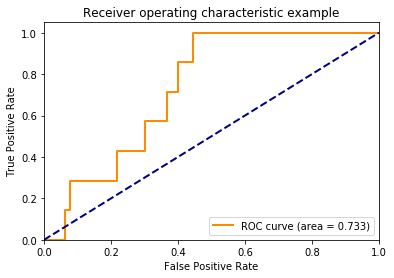

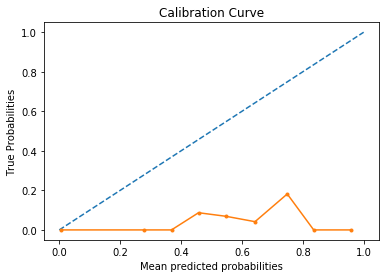

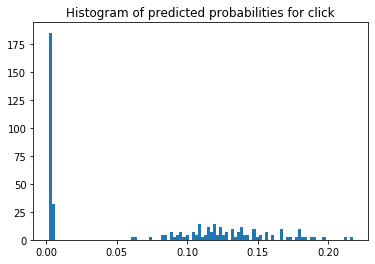

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
catboost,0.96,0.0,0.0,0.732791,-1.381555,0.217603,"{""min_data_in_leaf"": 100, ""depth"": 8, ""l2_leaf..."


In [227]:
catboost_results = evaulate_pipeline(catboost_pipe, X_val, y_val, best_catboost_params)
catboost_df = pd.DataFrame(catboost_results, index= ['catboost'])
catboost_df

# Model 3: KNN Classifier 

In [228]:
def make_knn_pipe_line(params = None) :
    encoder = ce.TargetEncoder(cols=cat_features)
    knn_model = KNeighborsClassifier(n_neighbors=300, weights='uniform')
    if params:
        knn_model.set_params(**params)
    return (Pipeline([('target_enc',encoder),  ('scaler',  StandardScaler()), ('KNN', knn_model)]))   

In [229]:
def find_best_params_knn(grid,X_train, y_train, X_val, y_val):
    best_metric = float('-inf')
    worst_metric = float('inf')
    for g in ParameterGrid(grid):
        print(g)
        model = make_knn_pipe_line(params = g)
        model.fit(X_train, y_train)
        y_hat = model.predict_proba(X_val)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_hat, pos_label=1)
        curr_metric = auc(fpr, tpr)

        # save if best
        if curr_metric > best_metric:
            best_metric = curr_metric
            best_grid = g
            
        if curr_metric < worst_metric:
            worst_metric = curr_metric
            worst_grid = g
    print ("Final Result")
    print ("best AUC metric", best_metric, ", Grid:", best_grid)
    print ("worst AUC metric", worst_metric, ", Grid:", worst_grid)
    return best_grid

### Parameters being tuned:
1. n_neighbors        = number of nearset neighbouring observation to consider for deciding on the prediciton
2. weights       = should all neighbours have equal weight or weighted by the distance to the observation


In [230]:
%%time
# Note: previous runs showed that uniform weighting is consistently better than distanced based weighting
# hence due to slow perfromance of this classifier, we avoid the distance based weighting option
if CALC_PARAMS:
    if dev_mode:
        knn_params_grid ={'n_neighbors': [500], 
                         'weights': ['uniform']
                        }
    else:
        knn_params_grid ={'n_neighbors': [500, 1000, 1500], 
                 'weights': ['uniform']
                }
    best_knn_params = find_best_params_knn(knn_params_grid, X_train, y_train, X_val, y_val)
    best_knn_params
else:
    best_knn_params = get_config('knn')

{'leaf_size': 30, 'n_neighbors': 1000, 'weights': 'uniform'}
Wall time: 4 ms


In [231]:
knn_pipeline = make_knn_pipe_line(params = best_knn_params)
knn_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('target_enc',
                 TargetEncoder(cols=['state', 'user_isp', 'app_cat',
                                     'banner_pos', 'manufacturer',
                                     'device_model', 'device_version',
                                     'Day_of_Week', 'Month', 'hour'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('KNN',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=1000, p=2,
                                      weights='uniform'))],
         verbose=False)

Best Threshold: 0.1 , with accuracy =  0.96


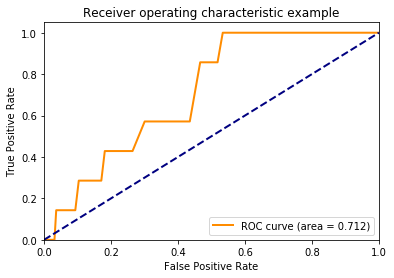

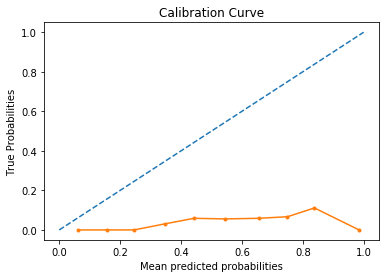

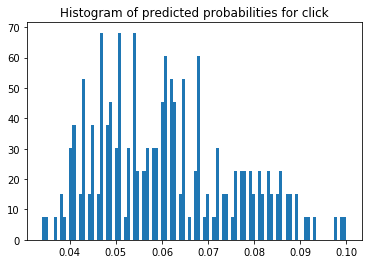

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
knn,0.96,0.0,0.0,0.711695,-1.381555,0.1,"{""leaf_size"": 30, ""n_neighbors"": 1000, ""weight..."


In [232]:
knn_results = evaulate_pipeline(knn_pipeline, X_val, y_val, best_knn_params);
knn_df = pd.DataFrame(knn_results, index= ['knn'])
knn_df

# summary of model metrics

In [233]:

metrics_df = pd.concat([rf_df, knn_df,catboost_df])
metrics_df.sort_values(by='AUC')

if CALC_PARAMS:
    now = datetime.datetime.now()
    now_string = now.strftime("%m_%d_%Y__%H_%M")
    metrics_df.reset_index().to_csv(f"configuration_{now_string}_sample_{SAMPLE}.csv", index=False)
metrics_df

,Accuracy,Recall,Precision,AUC,-LogLoss(higer is better),threshold,params
RF,0.96,0.0,0.0,0.796447,-1.381555,0.187430,"{""class_weight"": null, ""criterion"": ""gini"", ""m..."
knn,0.96,0.0,0.0,0.711695,-1.381555,0.100000,"{""leaf_size"": 30, ""n_neighbors"": 1000, ""weight..."
catboost,0.96,0.0,0.0,0.732791,-1.381555,0.217603,"{""min_data_in_leaf"": 100, ""depth"": 8, ""l2_leaf..."


# Exaplinable AI:  Shap Values

In [234]:
model = catboost_pipe


# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.initjs()


### Overview Of Shap
- Shap Values (Shapely Additive exPlanations) is a model Agnostic method for explaining model predictions\
It is based on theory developed by Loid Shapley in the 1950's
- Shap explains a model output additivley as the sum of each variables contribution
- shap is model agnostic but has fast implementations for tree based models
- Shap is the ONLY explanation method that satisifes a set of basic properties which are natural to be required from any valid explanation method:\
1. Local accuracy: - the shap value for a given observation Xi is equal to the model prediction for Xi
2. Missingness:  A missing value has zero contribution in the explanation
3. Consistency: If the importance of a variable in model B is not smaller than in model A then its shap value for model B will not be lower than for model A


## Shap Summary Plot

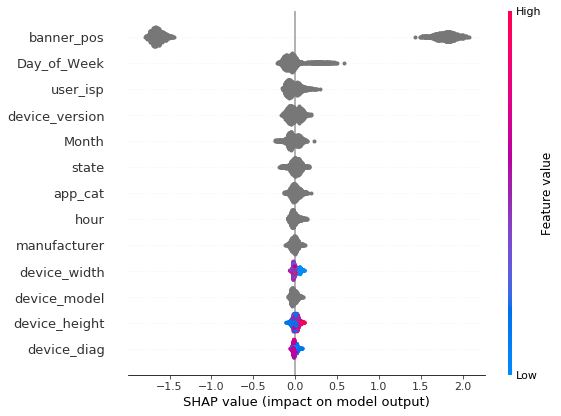

In [235]:

shap.summary_plot(shap_values)

#### explanation
This graph is actually a series of dot-plots:every observation(row) is representated as a dot
for each variable in the model we have a dot-plot showing a dot for each observation in the train set
X-axis: The shap value i.e. the negative or positive contribution of the observation's variable to the final prediction
Y-axis: in case where many observation have the same shap value the dots are stacked vertically
Color: For continuous variables the color represent whether the value of the variable is high or low in the observation

##### Example: TODO verify
in the device_diag variable we see that large screens (strong red) are associated with increased (positive) probability for a click

In [236]:

def explain_simple(idx, X_train):
    data = X_train.iloc[[idx]]
    shap_values = explainer.shap_values( data)
    return (shap.force_plot(explainer.expected_value,shap_values , data, link='logit'))

## 3 random predictions local explanations

In [237]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [238]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

In [239]:
explain_simple(random.randint(1, X_train.shape[0]), X_train)

# Section 8: Prediction on external data set

In [240]:
model = catboost_pipe


In [241]:
testset = pd.read_csv("ctr_dataset_test.csv")

# Apply preprocessing pipeline

In [242]:
%%time

X_test, _ = preprocessing_pipeline(testset, one_hot_encoding=USE_SMOTE, allowed_levels_dict = allowed_levels_dict)




Wall time: 4.33 s


### Add empty dummy columns for levels that are possibly missing in the predicitons data set

In [243]:
MODEL_COLS.remove('clicked')
unknown_cols = [c for c in MODEL_COLS  if c not in X_test.columns ]
for c in unknown_cols:
    print(f"adding default column for {c}")
    X_test.loc[:, c] = 0

In [244]:
print ([c for c in X_test.columns if c not in MODEL_COLS])
X_test = X_test[MODEL_COLS]


[]


In [245]:
y_hat = model.predict_proba(X_test)

In [246]:
best_threshold_catboost = catboost_df['threshold'].values[0]
best_threshold_catboost

0.21760337151660855

In [247]:
y_pred = (y_hat[:,1] >= best_threshold_catboost).astype(int)
predictions = pd.Series(y_pred)

#### Total predictions , total clicks predicted,  Percentage of predicted clicks:

In [248]:
f"N={predictions.count()}, Clicks={predictions.sum()}, Clicks Percent= {round(predictions.mean()*100,3)}%"

'N=629764, Clicks=7334, Clicks Percent= 1.165%'

# Group 8 output

In [249]:
predictions.to_csv('output_8.txt', index=False)

The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [250]:
datetime.datetime.now()

datetime.datetime(2022, 1, 15, 23, 23, 54, 119747)